In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [5]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsT_0256.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(100,100)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (82.24888676, 42.50111471)>


In [8]:
x = [82.150936,82.110034,82.158453,82.197666,82.182192,82.192476,82.113757,82.104471,82.095256,82.125836]
y = [42.449436,42.452321,42.478781,42.42245,42.480211,42.437444,42.478844,42.440872,42.420703,42.407897]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\2V Reduced\1500 1500 files')
file = 'reduceducdT_0256.fits'
image = pf.getdata(file)


a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -10<(k-xref)<10 and -10<(l-yref)<10:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[ 921.92344051 1268.9204088   860.93368725  523.11238195  659.91913495
  568.59611261 1239.67202368 1315.09510843 1391.51865506 1131.01985137]
[ 700.94725834  670.6146431   363.63795368 1007.27600765  345.52085614
  835.58248858  365.97366888  802.37573634 1034.44637743 1179.39945832]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
709 920.08743 694.16346 0.45678649 ...   0 66.149734 1.8959402 -0.6945616
 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
678 1269.5976 663.94045 0.48522973 ...   0 36.980722 1.2714885 -0.26078111
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
349 861.57012 361.16649 0.39563271 ...   0 631.81984 13.344772 -2.8132779
 id xcentroid ycentroid sharpness roundness1 

In [4]:
len(positions)

9

In [9]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=10) 
    annulus_aperture = CircularAnnulus(i, r_in=17., r_out=20.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

In [19]:
len(mags)

9

[  0.4088055  -18.85781646]
[[ 0.00307903 -0.03820284]
 [-0.03820284  0.48875351]]
Beta: [  0.40313083 -18.77144207]
Beta Std Error: [0.07440007 1.04277611]
Beta Covariance: [[ 1.16738603e-05 -1.62207026e-04]
 [-1.62207026e-04  2.29324260e-03]]
Residual Variance: 474.1678963372354
Inverse Condition #: 0.05213938672526807
Reason(s) for Halting:
  Sum of squares convergence


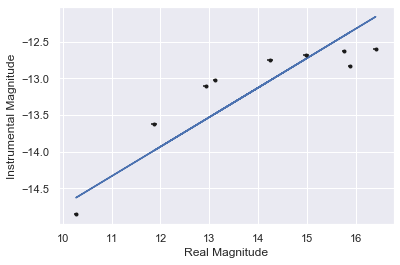

In [11]:
#magserrors.remove(magserrors[2])
#mags.remove(mags[2])
realmag = [15.758,16.402,13.119,15.872,13.806,10.272,12.923,14.232,11.868,14.98]
realmag.remove(realmag[4])
realmag = np.array(realmag)
realmagerrors = [0.036,0.054,0.037,0.041,0.057,0.041,0.049,0.063,0.058,0.066]
realmagerrors.remove(realmagerrors[4])
plt.errorbar(realmag,mags,magserrors,realmagerrors,fmt='.',color='k')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def f(x,m,c):
    return m*x+c
popt, pcov = curve_fit(f,realmag,mags,sigma=magserrors)
print(popt)

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(realmag, mags, sx = realmagerrors, sy = magserrors)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*realmag+myoutput.beta[1]
plt.plot(realmag,y)
print(pcov)
myoutput.pprint()

In [13]:
xref = 816
yref = 833

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id  xcentroid ycentroid sharpness  ... sky    peak      flux       mag     
---- --------- --------- ---------- ... --- --------- --------- ------------
1193 1130.3987 1179.3451 0.37791569 ...   0 123.25655 3.0532637   -1.2119108
 642 418.66874 627.19949 0.47564114 ...   0 12.592826  1.047672 -0.050563344
 839 814.18354 833.18784 0.41928481 ...   0  12651.57  274.8564   -6.0977646


In [18]:
sourcemag = []
sourcemagerror = []
position = [(814.18354,833.18784)]
aperture = CircularAperture(position[0], r=10) 
annulus_aperture = CircularAnnulus(position[0], r_in=17., r_out=20.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append((-1.08574/phot_table['aperture_sum_0'][0])*np.sqrt(phot_table['aperture_sum_0'][0]))
print(sourcemag)

[-15.172817026568746]


In [19]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

8.926692726934393 +/- 3.0667824127254484
